# Neural Additive Models
This notebook explores the model explainability(?) for Heart Disease Prediction Dataset using logistig regression with lasso regularization.

In [2]:
# Enable autoreload for imports
%load_ext autoreload
%autoreload 2

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from config import config

In [3]:
# Load the dataset
data = pd.read_csv(config.datapath / Path("train_val_split.csv"))
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,M,ATA,120,157,0,Normal,182,N,0.0,Up,0
730,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
731,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
732,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1


In [4]:
# Numerical and categorical features
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
label = 'HeartDisease'

In [5]:
data_one_hot = pd.get_dummies(data, columns=categorical_features, dtype=int)
data_one_hot

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,FastingBS_0,FastingBS_1,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,172,0.0,0,0,1,0,1,...,1,0,0,1,0,1,0,0,0,1
1,37,130,283,98,0.0,0,0,1,0,1,...,1,0,0,0,1,1,0,0,0,1
2,48,138,214,108,1.5,1,1,0,1,0,...,1,0,0,1,0,0,1,0,1,0
3,54,150,195,122,0.0,0,0,1,0,0,...,1,0,0,1,0,1,0,0,0,1
4,39,120,339,170,0.0,0,0,1,0,0,...,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,120,157,182,0.0,0,0,1,0,1,...,1,0,0,1,0,1,0,0,0,1
730,57,140,241,123,0.2,1,1,0,1,0,...,1,0,0,1,0,0,1,0,1,0
731,45,110,264,132,1.2,1,0,1,0,0,...,1,0,0,1,0,1,0,0,1,0
732,68,144,193,141,3.4,1,0,1,1,0,...,0,1,0,1,0,1,0,0,1,0


In [6]:
train, val = train_test_split(data_one_hot, test_size=0.1, stratify=data_one_hot[label], random_state=42)

In [7]:
scaler = StandardScaler()
scaler.fit(train[numerical_features])

train[numerical_features] = scaler.transform(train[numerical_features])
val[numerical_features] = scaler.transform(val[numerical_features])

In [8]:
# Create training and validation data loaders

BATCH_SIZE = 32

train_dataset = TensorDataset(
    torch.tensor(train.drop(columns=[label]).values.tolist()).to(torch.float32),
    torch.tensor(train[label].values.tolist()).to(torch.float32)
)

sampler = torch.utils.data.sampler.RandomSampler(train_dataset)
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=BATCH_SIZE)

val_dataset = TensorDataset(
    torch.tensor(val.drop(columns=[label]).values.tolist()).to(torch.float32),
    torch.tensor(val[label].values.tolist()).to(torch.float32)
)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [9]:
# Load the test data
test_data = pd.read_csv(config.datapath / Path("test_split.csv"))

# Transform the test data
test = pd.get_dummies(test_data, columns=categorical_features, dtype=int)
test[numerical_features] = scaler.transform(test[numerical_features])

# Create test data loader
test_dataset = TensorDataset(
    torch.tensor(test.drop(columns=[label]).values.tolist()).to(torch.float32),
    torch.tensor(test[label].values.tolist()).to(torch.float32)
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [10]:
# Define the model

class ExU(nn.Module):
    def __init__(self, in_dim: int, out_dim: int) -> None:
        super(ExU, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_dim, out_dim))
        self.bias = nn.Parameter(torch.Tensor(in_dim))
        self.init_params()

    
    def init_params(self) -> None:
        self.weight = nn.init.normal_(self.weight, mean=4., std=.5)
        self.bias = nn.init.normal_(self.bias, std=.5)

    
    def forward(self, x) -> torch.Tensor:
        out = torch.matmul((x - self.bias), torch.exp(self.weight))
        out = torch.clamp(out, 0, 1)
        return out


class ReLU(nn.Module):
    def __init__(self, in_dim: int, out_dim: int) -> None:
        super(ReLU, self).__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.init_params()


    def init_params(self) -> None:  
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.normal_(self.linear.bias, std=.5)


    def forward(self, x) -> torch.Tensor:
        out = self.linear(x)
        out = F.relu(out)
        return out
    
class FeatureNet(nn.Module):
    def __init__(self, hidden_sizes, dropout_rate = .2, use_exu = True) -> None:
        super(FeatureNet, self).__init__()
        layers = [
            ExU(1, hidden_sizes[0]) if use_exu else ReLU(1, hidden_sizes[0])
        ]
        input_size = hidden_sizes[0]
        for s in hidden_sizes[1:]:
            layers.append(ReLU(input_size, s))
            layers.append(nn.Dropout(dropout_rate))
            input_size = s
        layers.append(nn.Linear(input_size, 1, bias = False))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

class NAM(nn.Module):
    def __init__(self, no_features, hidden_sizes, dropout_rate = 0.2, feature_dropout = 0.0, use_exu = False) -> None:
        super(NAM, self).__init__()
        self.no_features = no_features
        feature_nets = [FeatureNet(hidden_sizes, dropout_rate, use_exu) for _ in range(no_features)]
        self.feature_nets = nn.ModuleList(feature_nets)
        self.feature_drop = nn.Dropout(feature_dropout)
        self.bias = torch.nn.Parameter(torch.zeros(1,), requires_grad=True)
            
    def forward(self, x):
        y = []
        for i in range(self.no_features):
            o = self.feature_nets[i](x[:,i].unsqueeze(1))
            y.append(o)
        y = torch.cat(y, 1)
        y = self.feature_drop(y)
        out = torch.sum(y, axis = -1) + self.bias
        out = torch.sigmoid(out)
        return out, y

In [11]:
# Train the 100 NAM models to plot shape functions 

LEARNING_RATE = 0.0001
DECAY = 0.001
EPOCHS = 25
REPLICATES = 100

results = []
for r in range(REPLICATES):

    model = NAM(
        no_features=data_one_hot.shape[1] - 1,
        hidden_sizes=[64, 64, 32],
        dropout_rate=0.1,
        feature_dropout=0.05,
        use_exu=False
    )

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=DECAY
    )

    loss = nn.BCELoss(reduction='none')  

    no_batches = len(train_loader)

    for epoch in range(EPOCHS):
        
        model.train()
        for i, (x, y) in enumerate(train_loader):
                                
            y_, p_ = model(x)
            pen = torch.norm(p_, dim = 1)
            err = loss(y_, y) #+ 0.2 * pen
            err = err.mean()
            
            err.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # print(f'Epoch: {epoch}/{EPOCHS}\t Err: {err.item():1.3f}')
        
        model.eval()
        val_true, val_pred, val_out = [], [], []
        with torch.no_grad():
            for i, (x, y) in enumerate(val_loader):
                y_, p_ = model(x)
                
                val_out.extend(p_.tolist())
                val_pred.extend(torch.where(y_ > 0.5, 1, 0).tolist())
                val_true.extend(torch.where(y > 0.5, 1, 0).tolist())
        
        # print(classification_report(val_true, val_pred))
    
    # Predict on test set
    model.eval()
    test_true, test_pred, test_out = [], [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            y_, p_ = model(x)
            test_out.extend(p_.tolist())
            test_pred.extend(torch.where(y_ > 0.5, 1, 0))
            test_true.extend(torch.where(y > 0.5, 1, 0))
          
    print(classification_report(test_true, test_pred))
    
    res = (
        pd
        .DataFrame(test_out, columns = test.drop(columns=[label]).columns, index=test.index)
        .add_suffix('_partial')
        .join(test)
        .assign(prediction = test_pred)   
        .assign(replicate = r + 1)         
    )
    # inverse scaling for numerical features in order to plot them on the original scale
    res[numerical_features] = scaler.inverse_transform(res[numerical_features])
    results.append(res)
 
# Calculate the average of the 100 replicates for F1 score and also for balanced accuracy


              precision    recall  f1-score   support

           0       0.81      0.77      0.79        74
           1       0.85      0.88      0.87       110

    accuracy                           0.84       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184

              precision    recall  f1-score   support

           0       0.73      0.77      0.75        74
           1       0.84      0.81      0.82       110

    accuracy                           0.79       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.80      0.79      0.79       184

              precision    recall  f1-score   support

           0       0.75      0.78      0.77        74
           1       0.85      0.83      0.84       110

    accuracy                           0.81       184
   macro avg       0.80      0.81      0.80       184
weighted avg       0.81      0.81      0.81       184

              preci

In [12]:
def plot_shape_functions(results, features, nrows = 1, size = (8, 10), fname = None):
    n = len(features)
    ncols = n // nrows
    plt.clf()
    plt.style.use('classic')
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = size)
    for i, feature in enumerate(features):
        r = i // ncols
        c = i % ncols
        
        results.sort_values(feature, inplace = True)
        for _, res in results.groupby('replicate'):
            x = (
                res[[feature, feature + '_partial']]
                .drop_duplicates(subset = feature)
                .set_index(feature)
            )

            x.plot.line(
                ax = axes[r, c], 
                color = 'orange', 
                lw = 0.25
            )

        x = results.pivot_table(
            index = feature, 
            columns = 'replicate', 
            values = feature + '_partial'
        )

        x = (
            x
            .interpolate()
            .mean(axis = 1)
            .rename(feature + '_partial')
            .sort_index()
        )

        x.plot.line(
            ax = axes[r, c], 
            color = 'orange', 
            lw = 1.5
        )
        
        # Plot frequencies        
        twin = axes[r, c].twinx()
        x = results[feature]
        if x.dtype == object:
            x.value_counts().plot.bar(
                width = 1, 
                alpha = .15,
                ax = twin,
            )    

            labs = [label.get_text() for label in twin.get_xticklabels()]
            axes[r, c].set_xticklabels(labs, rotation=45, ha='right')
            
        else:
            x.plot.hist(
                alpha = .15, 
                ax = twin
            )
        twin.set_ylabel('frequnecy')
    
        axes[r, c].grid(True)
        axes[r, c].set_ylabel('Shape functions')
        axes[r, c].xaxis.label.set_visible(False)
        axes[r, c].set_title(feature.replace('_', ' '))
        axes[r, c].get_legend().remove()

    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

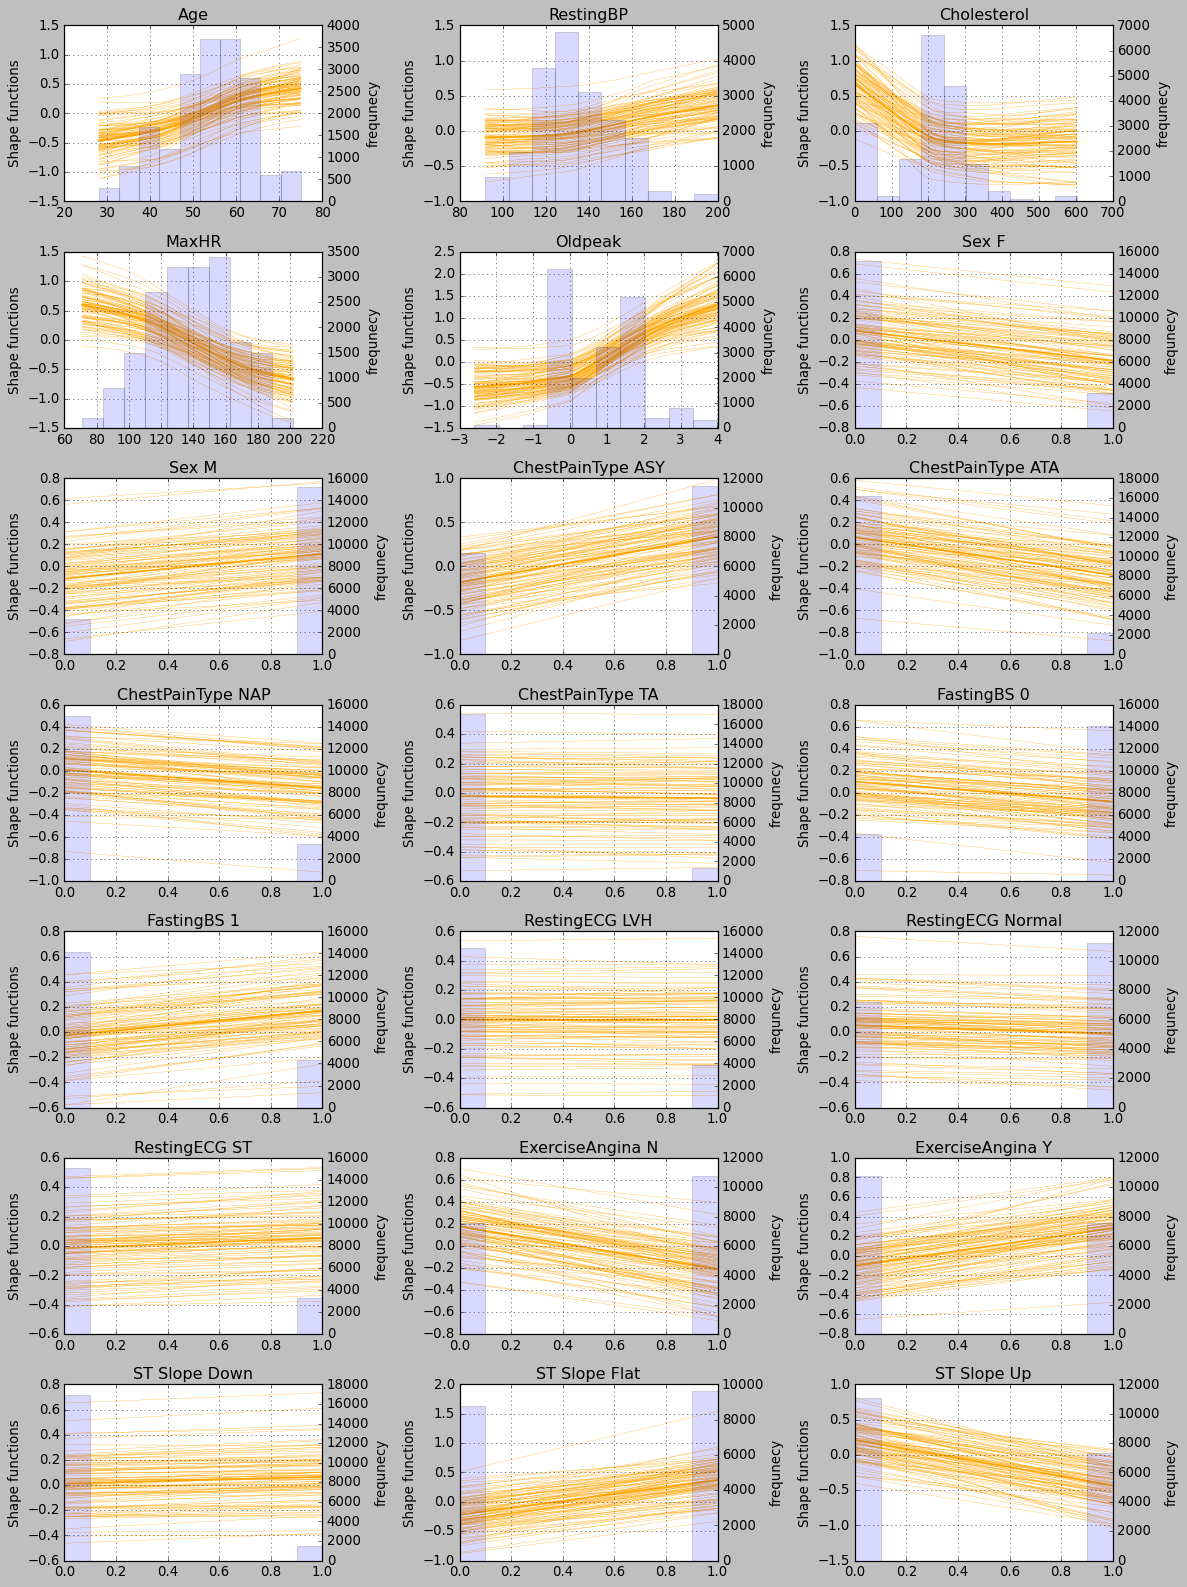

In [13]:
plot_shape_functions(
        pd.concat(results), 
        test.drop(columns=[label]).columns, 
        nrows=7,
        size=(15, 20),
)